In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import re
from matplotlib.markers import MarkerStyle
from matplotlib import gridspec

from scipy import integrate

In [3]:
DIRNAME = os.path.abspath("")
PLOTS_PATH = os.path.join(DIRNAME, "Plots")
DATA_DIR = os.path.join(os.path.dirname(DIRNAME), "FINO1Data")
ARRAY_PATH = os.path.join(DIRNAME, "Arrays")


os.makedirs(ARRAY_PATH, exist_ok=True)
os.makedirs(PLOTS_PATH, exist_ok=True)

p_list = [1,2,4,10]
gust_ths = [1,1.5,2]
betas = [1, 0.644]
dname = "2015-2017_100m"

In [4]:
main_root = os.path.join(ARRAY_PATH, dname, "AutoRegression2")
roots = {}
for root, dir, fnames in os.walk(os.path.join(ARRAY_PATH, f"{dname}","AutoRegression2")):
    if any(fname.endswith(".dat") for fname in fnames):
        roots.update({root.replace(main_root, "")[1:]: {fname.replace(".dat", ""): pd.read_csv(os.path.join(root, fname), delimiter=" ", header=None, names=["TPR", "FPR"]) for fname in fnames if fname.endswith(".dat")}})

In [5]:
train_pers = [9, 16, 60, 120, 308, 500, 1242, 26265600]
modes = ["a", "b", "c", "d"]
processed_dict_performances = {}


for p in p_list:
    for gust_th in gust_ths:
        mode_dict_performances = dict.fromkeys(modes)

        for mode in modes: mode_dict_performances[mode] = dict.fromkeys(train_pers)


        for mode in modes:
            beta = 0.644 if mode == "d" else 1
            performances = roots[f"{os.path.join(f'AR({p})', f'GustTh={gust_th}', f'Beta={beta}')}"]

            for fname, performance in performances.items():
                train_per_match = re.search(r"training_per=([\d.]+)", fname)
                train_per = train_per_match.group(1) if train_per_match else None

                if int(train_per) in train_pers:
                    mode_dict_performances[fname[-1]][int(train_per)] = performance

        processed_dict_performances[f"{os.path.join(f'AR({p})', f'GustTh={gust_th}')}"] = mode_dict_performances



In [18]:
def plot_roc(*, processed_dict_performances, train_pers):


    colors = sns.color_palette("rocket_r", len(train_pers))
    fig = plt.figure(figsize=(30,45))

    modes = ["a", "b", "c", "d"]
    
    gs = gridspec.GridSpec(4, 3, width_ratios=[1,1,1], height_ratios=[1,1,1,1], figure=fig, wspace=0.1, hspace=0.25)

    for i, p in enumerate(p_list):
        for j, gust_th in enumerate(gust_ths):
            sub_gs = gs[j+i*len(gust_ths)].subgridspec(2,2, wspace=0.1, hspace=0.1, width_ratios=[1,1], height_ratios=[1,1])

            for k, mode in enumerate(modes):
              
                ax0 = fig.add_subplot(sub_gs[k])
                ax0.set_title(f"({mode})", fontsize=20)
                try:
                    dict_performances = processed_dict_performances[f"{os.path.join(f'AR({p})', f'GustTh={gust_th}')}"][mode]
                except: pass
                for idx, train_per in enumerate(train_pers):
                    try: 
                        performance = dict_performances[train_per]
                        ax0.scatter(performance["FPR"], performance["TPR"], color=colors[idx], s=10, label=train_per)
                    except: pass

                    
                plt.plot(np.arange(2), linestyle="--", color='#0f0f0f30')
                plt.grid(linewidth=0.4, alpha=0.8)

                xticks = np.linspace(0,1,6)
                yticks = np.linspace(0,1,6)
                plt.xlim(0,1)
                plt.ylim(0,1)
                plt.minorticks_on()
                plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
                plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
                plt.xticks(xticks)
                plt.yticks(yticks)


                plt.xlabel("$FPR$", fontsize=12)
                plt.ylabel("$TPR$", fontsize=12)

            ax_abcd = fig.add_subplot(sub_gs[:])
            ax_abcd.axis('off')
            ax_abcd.set_title(r"$u_{\times}="+f"{gust_th}$", fontsize=30)
            
        ax0.legend(title=r"Training period $\tau$ $[s]$", fontsize=20)
            



    plt.savefig(os.path.join(PLOTS_PATH, "ROCs2.png"), format="png", dpi=300, bbox_inches="tight")

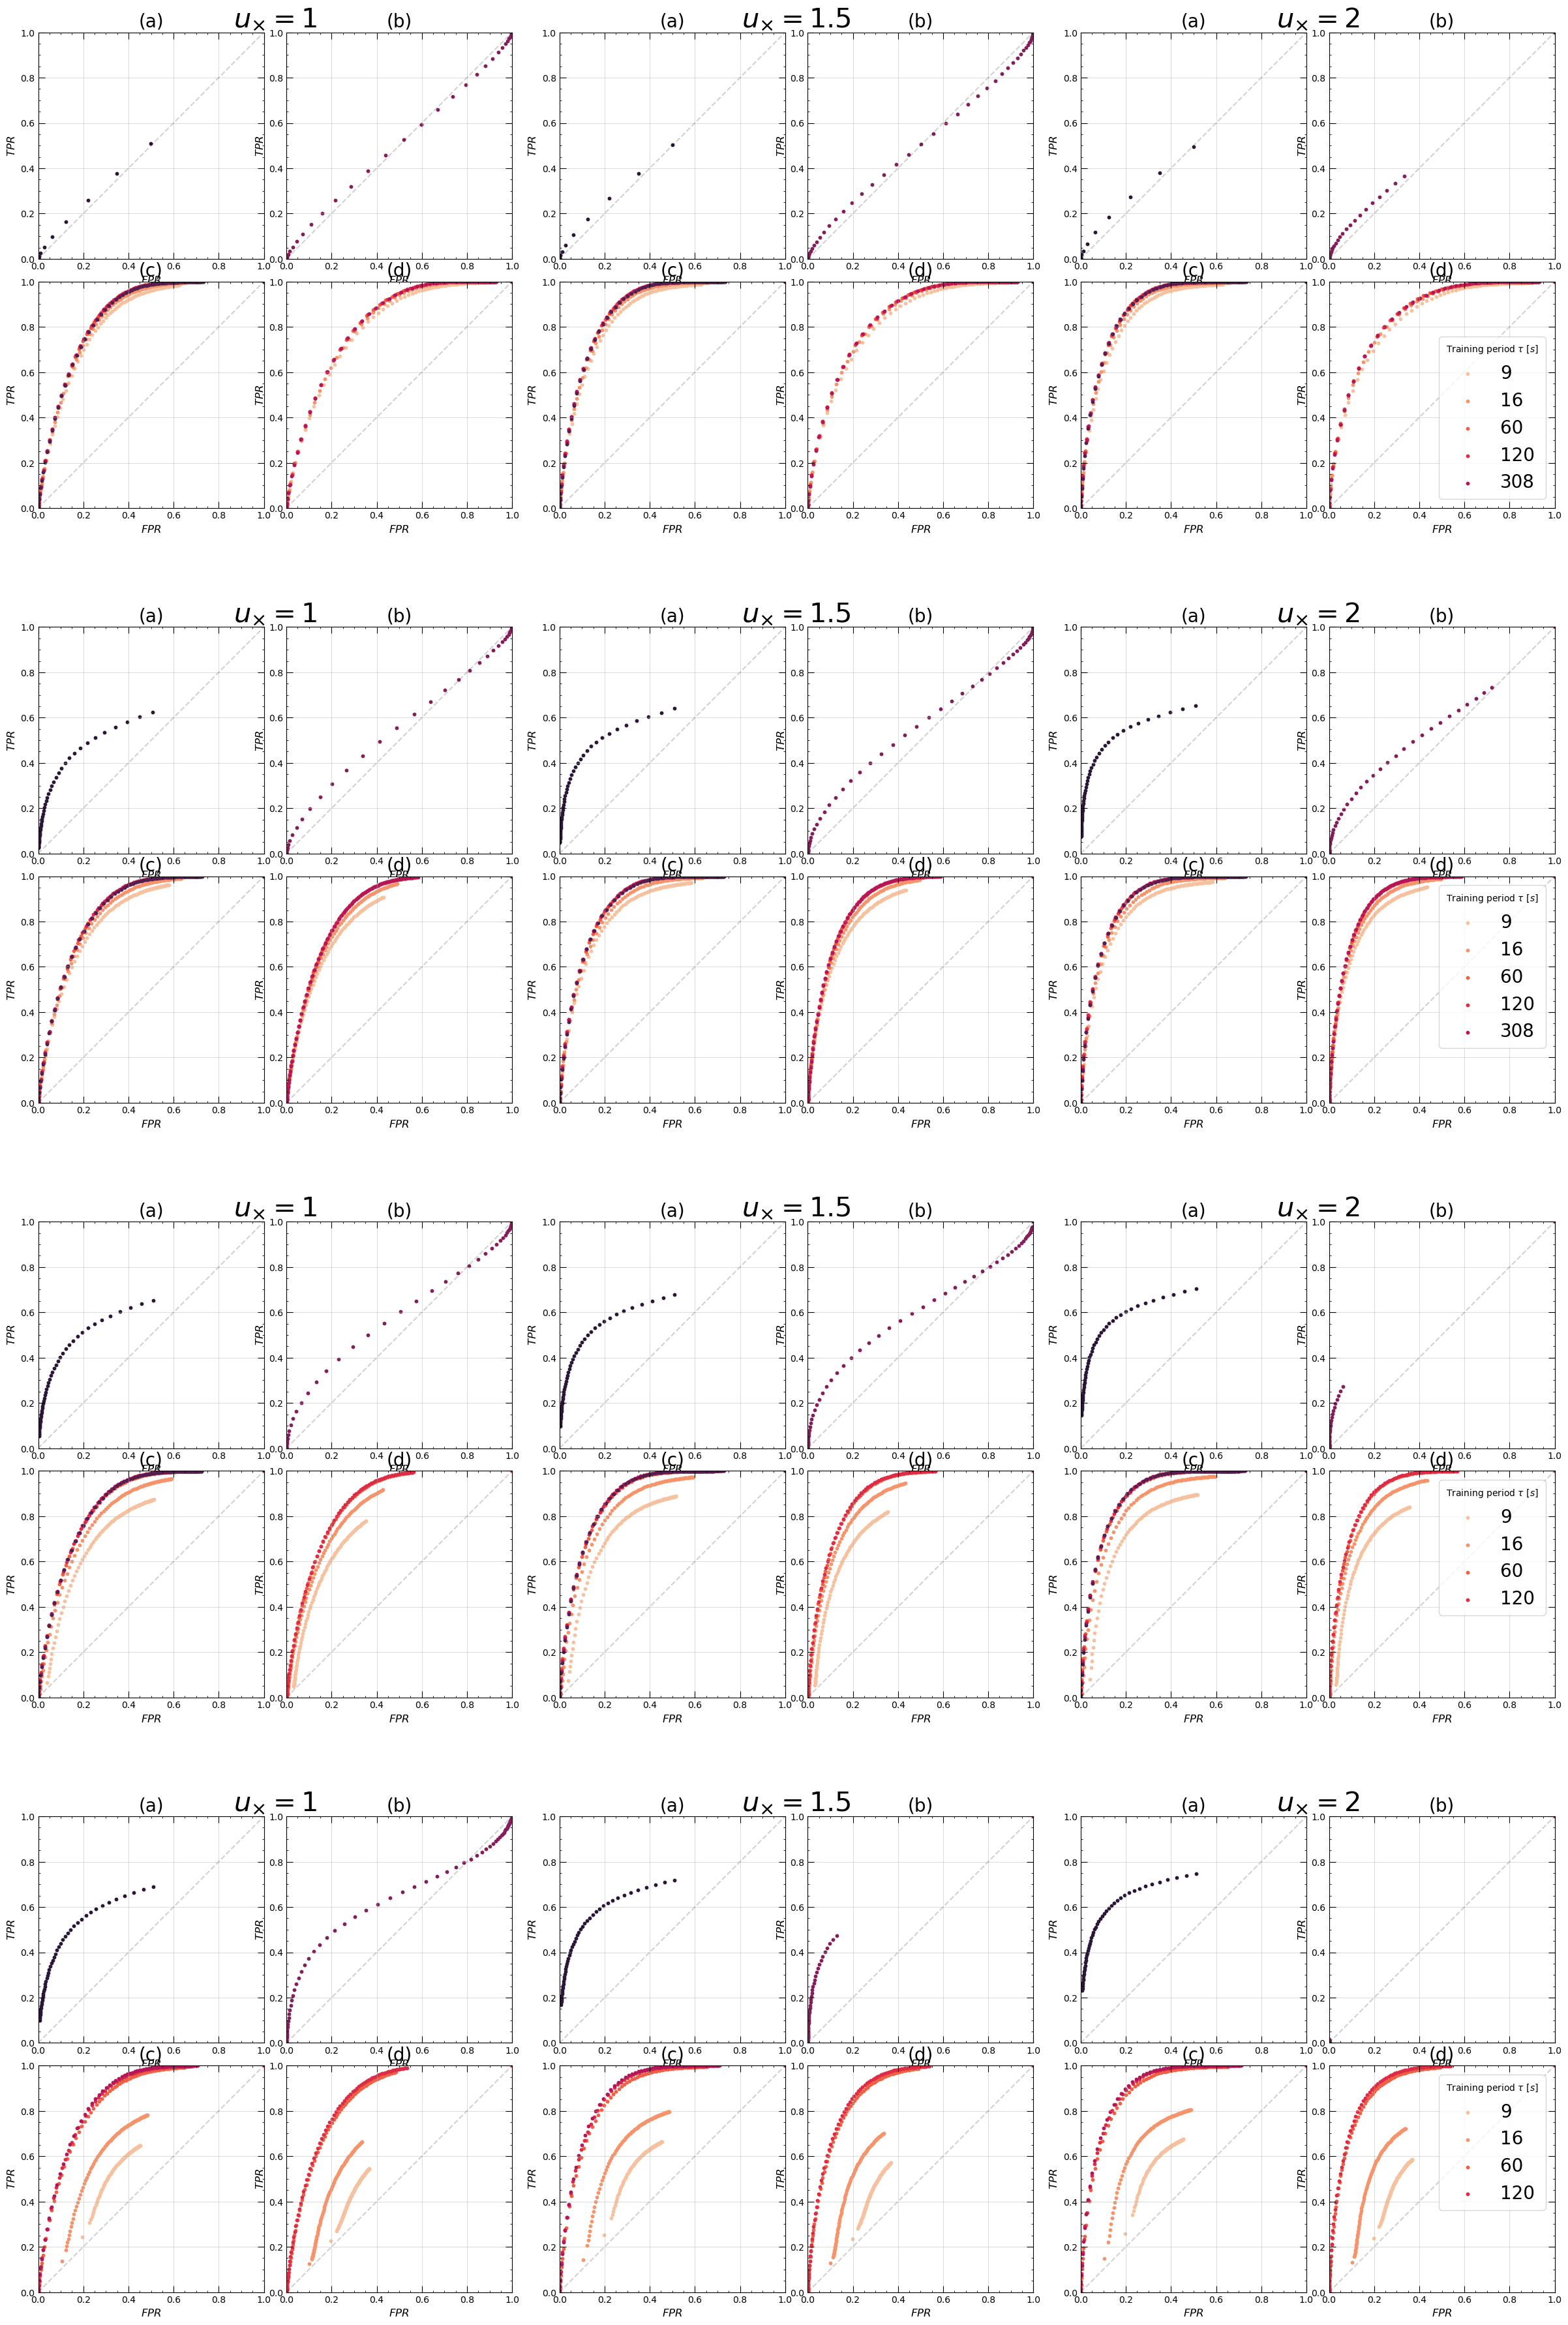

In [19]:
plot_roc(processed_dict_performances=processed_dict_performances, train_pers=train_pers)

In [8]:
def get_auc(performance):
    integy = np.flip(performance["TPR"])
    integx = np.flip(performance["FPR"])
    return integrate.trapezoid(y=integy, x=integx)

def get_xi_opt(performance):
    return max(abs(performance["TPR"] - performance["FPR"]) / 2**0.5)

In [9]:
# np.unique(np.round(10**np.linspace(np.log10(5), np.log10(10*24*60*60), 200))).astype(int)

In [323]:
p_aucs = []
p_xis = []

for p in p_list:
    performances = roots[f"{os.path.join(f'AR({p})', f'GustTh=1', f'Beta=1')}"]

    aucs = {}
    xis = {}
    
    for fname, performance in performances.items():
        if fname.endswith("c"):
            train_per_match = re.search(r"training_per=([\d.]+)", fname)
            train_per = train_per_match.group(1) if train_per_match else None
            
            aucs[int(train_per)] = get_auc(performance)
            xis[int(train_per)] = get_xi_opt(performance)

    p_aucs.append(aucs)
    p_xis.append(xis)

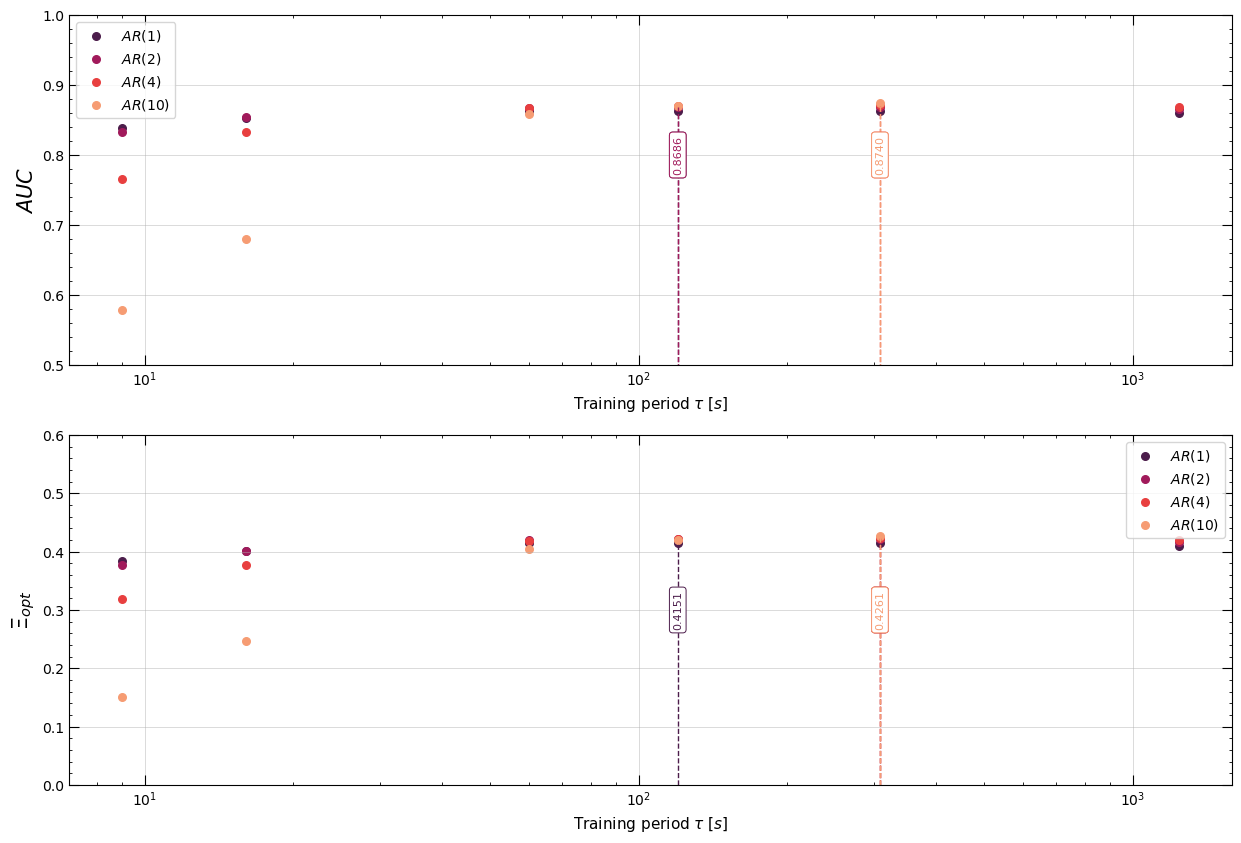

In [324]:
def plot2(*, p_scores):
    fig, (ax0, ax1) = plt.subplots(2,1, figsize=(15,10))

    colors = sns.color_palette("rocket", len(p_scores[0]))

    for j, aucs in enumerate(p_scores[0]):

        #auc_th = list(filter(lambda x: (aucs[x]>0.9), aucs.keys()))
        max_key = max(aucs, key=aucs.get)

        ax0.vlines(max_key,linestyles="--", ymin=0, ymax=aucs[max_key], linewidth=1, color=colors[j], alpha=1)
        ax0.annotate(f"{aucs[max_key]:.4f}", xy=(max_key, 0.8), rotation=90, 
                    va="center", ha="center", fontsize=8,
                    bbox=dict(boxstyle="round", fc="w", linewidth=0.7, color=colors[j]), alpha=1, color=colors[j])
        
        ax0.scatter(aucs.keys(), aucs.values(), marker=MarkerStyle('o', fillstyle='full'), s=30, color=colors[j], label=f"$AR({p_list[j]})$")
        ax0.set_xlabel(r"Training period $\tau$ $[s]$", fontsize=11)
        ax0.set_ylabel(r"$AUC$", fontsize=15)
        ax0.set_xscale("log")
        ax0.set_ylim(0.5, 1)

        ax0.grid(linewidth=0.4, alpha=0.8)

        ax0.legend()

        ax0.minorticks_on()
        ax0.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
        ax0.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)


    for j, xis in enumerate(p_scores[1]):

        #auc_th = list(filter(lambda x: (xis[x]>0.9), xis.keys()))
        max_key = max(xis, key=xis.get)

        ax1.vlines(max_key,linestyles="--", ymin=0, ymax=xis[max_key], linewidth=1, color=colors[j], alpha=1)
        ax1.annotate(f"{xis[max_key]:.4f}", xy=(max_key, 0.3), rotation=90, 
                    va="center", ha="center", fontsize=8,
                    bbox=dict(boxstyle="round", fc="w", linewidth=0.7, color=colors[j]), alpha=1, color=colors[j])
        
        ax1.scatter(xis.keys(), xis.values(), marker=MarkerStyle('o', fillstyle='full'), s=30, color=colors[j], label=f"$AR({p_list[j]})$")


        ax1.set_xlabel(r"Training period $\tau$ $[s]$", fontsize=11)
        ax1.set_ylabel(r"$\Xi_{opt}$", fontsize=15)
        ax1.set_xscale("log")
        ax1.set_ylim(0, 0.6)

        ax1.grid(linewidth=0.4, alpha=0.8)

        ax1.legend()

        ax1.minorticks_on()
        ax1.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
        ax1.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
        
    #plt.savefig(os.path.join(PLOTS_PATH, "scors.png"))

plot2(p_scores=[p_aucs, p_xis])

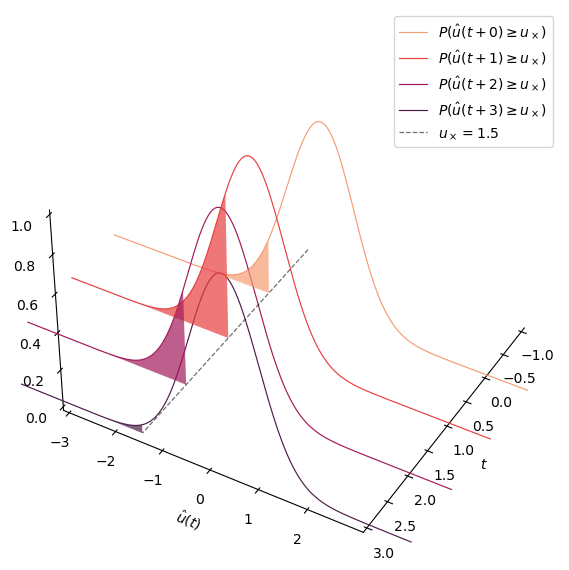

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]




f_g = lambda x, mu: np.exp(-(x+mu)**2)

fig = plt.figure(figsize=(7,7))
colors = sns.color_palette("rocket_r", 4)
ax = fig.add_subplot(projection=Axes3D.name)


for i in range(4):
    
    a = -5
    b = 4
    mu = np.sin(i+0.4)
    ys = np.linspace(a,b,200)
    ys_fill = np.linspace(a,-1.5,200)

    ax.plot(xs=np.ones(200)*i, ys=ys, zs=f_g(ys, mu), color=colors[i], linewidth=0.85, label=r"$P(\hat{u}"+f"(t+{i})" + r"\geq u_\times)$")
    verts = [polygon_under_graph(x=ys_fill, y=f_g(ys_fill, mu))]

    poly = PolyCollection(verts, facecolors=colors[i], alpha=.7)
    ax.add_collection3d(poly, zs=i, zdir='x')



ax.plot(xs=np.arange(5)-1, ys=-np.ones(5)*1.5,zs=np.zeros(5), linestyle="--", color="#0f0f0f99", linewidth=0.9, label=r"$u_\times=1.5$")

ax.legend()



ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(40,30)
ax.grid(False)

ax.set_xlim(-1,3)
ax.set_ylim(-3,3)
ax.set_zlim(0,1)


yticks = np.arange(-3,3)
#plt.xticks(xticks)
plt.yticks(yticks)

ax.set_xlabel("$t$")
ax.set_ylabel(r"$\hat{u}(t)$")

plt.savefig(os.path.join(PLOTS_PATH, "ProbabilityThreshold.png"), format="png", dpi=300, bbox_inches="tight" )

In [326]:
def single_plot_roc(*, performance):

    colors = sns.color_palette("rocket", len(performance))
    fig = plt.figure(figsize=(5,5))



    plt.scatter(performance["FPR"], performance["TPR"], color=colors[20], s=10,label=train_per)
            
    plt.plot(np.arange(2), linestyle="--", color='#0f0f0f30')
    plt.grid(linewidth=0.4, alpha=0.8)

    xticks = np.linspace(0,1,6)
    yticks = np.linspace(0,1,6)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.minorticks_on()
    plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
    plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)
    plt.xticks(xticks)
    plt.yticks(yticks)


    plt.xlabel("$FPR$", fontsize=10)
    plt.ylabel("$TPR$", fontsize=10)
        



    #plt.savefig(os.path.join(PLOTS_PATH, "test2.png"), format="png", dpi=300, bbox_inches="tight")

0.8390184648486066


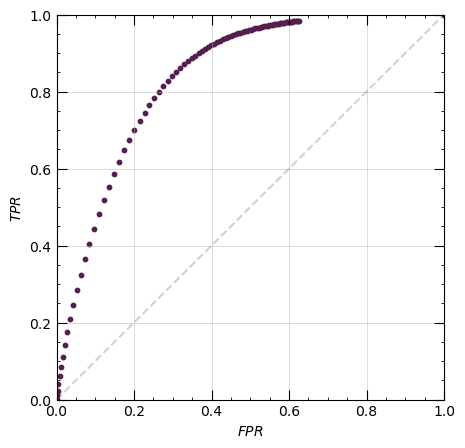

In [327]:
fname = r"C:\Users\Maik\Documents\MyProjects\BachelorThesis\Models\WindGust\Arrays\2015-2017_100m\AutoRegression2\AR(1)\GustTh=1\Beta=1\2015-2017_100m-p=1-training_per=9-gust_th=1-beta=1-mode=c.dat"
performance = pd.read_csv(fname,
                          delimiter=" ", header=None, names=["TPR", "FPR"])

print(get_auc(performance))
single_plot_roc(performance=performance)